<img src="https://www.mmu.edu.my/fci/wp-content/uploads/2021/01/FCI_wNEW_MMU_LOGO.png" style="height: 80px;" align=left>  

# Learning Objectives

Towards the end of this lesson, you should be able to:
- construct and perform inferencing using Bayesian Network
- train and tune SVM for classification


---

## Bayesian Networks

Bayesian network is provided by the [pgmpy](https://pgmpy.org/index.html) package.

In [1]:
!pip install pgmpy


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


There are various types Bayesian Networks, but for this exercise, we will be using the standard [Discrete Bayesian Network](https://pgmpy.org/examples/Creating%20a%20Discrete%20Bayesian%20Network.html).

For the construction, we need to create the network structure (qualitative part) and the the Conditional Probability Tables (quantitative part). So let's import the necessary methods.

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD

To define the network structure, we have to pass the nodes in pairs:

In [3]:
# Defining the model structure. We can define the network by just passing a list of edges.
cancer_model = BayesianNetwork(
    [
        ("Pollution", "Cancer"),
        ("Smoker", "Cancer"),
        ("Cancer", "Xray"),
        ("Cancer", "Dyspnoea"),
    ]
)


Following that, the conditional probability tables for each node can be constructed as follows:


In [4]:
cpd_poll = TabularCPD(variable="Pollution",
                      variable_card=2,
                      values=[[0.9], [0.1]],
                      state_names={"Pollution":["no","yes"]})

cpd_smoke = TabularCPD(variable="Smoker",
                       variable_card=2,
                       values=[[0.3], [0.7]],
                      state_names={"Smoker":["no","yes"]})

cpd_cancer = TabularCPD(
    variable="Cancer",
    variable_card=2,
    values=[[0.55, 0.25, 0.05, 0.001], [0.45, 0.75, 0.95, 0.999]],
    evidence=["Smoker", "Pollution"],
    evidence_card=[2, 2],
    state_names={"Cancer":["no","yes"],"Pollution":["no","yes"],"Smoker":["no","yes"]}
)
cpd_xray = TabularCPD(
    variable="Xray",
    variable_card=2,
    values=[[0.9, 0.2], [0.1, 0.8]],
    evidence=["Cancer"],
    evidence_card=[2],
    state_names={"Xray":["no","yes"],"Cancer":["no","yes"]}
)
cpd_dysp = TabularCPD(
    variable="Dyspnoea",
    variable_card=2,
    values=[[0.65, 0.3], [0.35, 0.7]],
    evidence=["Cancer"],
    evidence_card=[2],
    state_names={"Dyspnoea":["no","yes"],"Cancer":["no","yes"]}
)

In [5]:
#Visualize the tables
print(cpd_poll), print(cpd_smoke)
print(cpd_cancer)
print(cpd_xray), print(cpd_dysp)

+----------------+-----+
| Pollution(no)  | 0.9 |
+----------------+-----+
| Pollution(yes) | 0.1 |
+----------------+-----+
+-------------+-----+
| Smoker(no)  | 0.3 |
+-------------+-----+
| Smoker(yes) | 0.7 |
+-------------+-----+
+-------------+---------------+-----+---------------+----------------+
| Smoker      | Smoker(no)    | ... | Smoker(yes)   | Smoker(yes)    |
+-------------+---------------+-----+---------------+----------------+
| Pollution   | Pollution(no) | ... | Pollution(no) | Pollution(yes) |
+-------------+---------------+-----+---------------+----------------+
| Cancer(no)  | 0.55          | ... | 0.05          | 0.001          |
+-------------+---------------+-----+---------------+----------------+
| Cancer(yes) | 0.45          | ... | 0.95          | 0.999          |
+-------------+---------------+-----+---------------+----------------+
+-----------+------------+-------------+
| Cancer    | Cancer(no) | Cancer(yes) |
+-----------+------------+-------------+
| X

(None, None)

Now that we have the structure and the probabilities, we can "add" them to build the model:

In [6]:
# Associating the parameters with the model structure.
cancer_model.add_cpds(cpd_poll, cpd_smoke, cpd_cancer, cpd_xray, cpd_dysp)

# Checking if the cpds are valid for the model.
cancer_model.check_model()

True

In order to verify the structure, we can visualize the network using the [Networkx](https://networkx.org/) and using the [`draw`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw.html).

In [7]:
!pip install networkx matplotlib


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


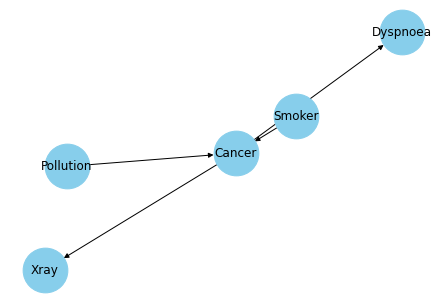

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
nx_graph = nx.DiGraph(cancer_model.edges())
nx.draw(
    nx_graph,
    with_labels=True,
    node_size=2000,
    node_color="skyblue",
    pos=nx.spring_layout(nx_graph)
)
plt.show()

After the construction, we can use the model for inferences.<br>
For inferencing, `pgmpy` provides 2 options:
1. Variable Elimination and,
2. Belief Propagation

Let's use the [VariableElimination](https://pgmpy.org/exact_infer/ve.html) method for the simple inferencing. We can either use the `query` to calculate the probabilities of the queried variable, or the `map_query` to get a "classification" given the evidences (attributes). The `map_query` essentially returns the highest probable state in the joint distribution of variables.

In [9]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(cancer_model)

# Computing the probability of Cancer given Smoker=no.
q = infer.query(variables=["Cancer"], evidence={"Smoker": "no"})
print(q)


+-------------+---------------+
| Cancer      |   phi(Cancer) |
+=============+===============+
| Cancer(no)  |        0.5200 |
+-------------+---------------+
| Cancer(yes) |        0.4800 |
+-------------+---------------+


In [10]:
# Computing the joint probability of Cancer and Pollution given Smoke=yes
q = infer.query(variables=["Cancer", "Dyspnoea"], evidence={"Smoker": "yes"})
print(q)

+-------------+---------------+------------------------+
| Cancer      | Dyspnoea      |   phi(Cancer,Dyspnoea) |
+=============+===============+========================+
| Cancer(no)  | Dyspnoea(no)  |                 0.0293 |
+-------------+---------------+------------------------+
| Cancer(no)  | Dyspnoea(yes) |                 0.0158 |
+-------------+---------------+------------------------+
| Cancer(yes) | Dyspnoea(no)  |                 0.2865 |
+-------------+---------------+------------------------+
| Cancer(yes) | Dyspnoea(yes) |                 0.6684 |
+-------------+---------------+------------------------+


In [11]:
# Computing the probabilities (not joint) of Cancer and Dyspnoea given smoke=no
q = infer.query(variables=["Cancer", "Dyspnoea"], evidence={"Smoker": "no"}, joint=False)
for factor in q.values():
    print(factor)

+-------------+---------------+
| Cancer      |   phi(Cancer) |
+=============+===============+
| Cancer(no)  |        0.5200 |
+-------------+---------------+
| Cancer(yes) |        0.4800 |
+-------------+---------------+
+---------------+-----------------+
| Dyspnoea      |   phi(Dyspnoea) |
+===============+=================+
| Dyspnoea(no)  |          0.4820 |
+---------------+-----------------+
| Dyspnoea(yes) |          0.5180 |
+---------------+-----------------+


In [12]:
# Computing the MAP of Cancer given Smoker=no.
q = infer.map_query(variables=["Cancer"], evidence={"Smoker": "no"})
print(q)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'Cancer': 'no'}


In [13]:
# Computing the MAP of Cancer and Dyspnoea given Smoker=yes
q = infer.map_query(variables=["Cancer", "Dyspnoea"], evidence={"Smoker": "yes"})
print(q)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

{'Cancer': 'yes', 'Dyspnoea': 'yes'}


Notice that the model can be used flexibly to get the probabilies, or "classification" even if the attributes given are incomplete.<br>
Try to get the probabilities and the MAP for Dyspnoea for the following case (Smoker = yes, Pollution = no, Xray = no, Cancer = yes).

In [41]:
q = infer.map_query(variables=["Dyspnoea"], evidence={"Smoker":"no","Pollution":"yes","Xray":"no","Cancer":"no"})
print(q)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Dyspnoea': 'no'}


---

## Support Vector Machine (SVM)
SVM is particularly powerful and flexible class of supervised algorithms for both classification and regression. In this section, we will develop the intuition behind support vector machines and their use in classification problems via [SVM provided by scikit-learn](https://scikit-learn.org/stable/modules/svm.html).

### Motivation of SVMs
Given two possible categories for data points to fall into, we can approach the classification task in one of two ways:
- *Generative algorithms* calculate the probability of a data point belonging to a certain class.
- *Discriminative algorithms*, on the other hand, identify the optimal boundary between classes.

SVMs are an example of a discriminative algorithm. While they may not seem as intuitively useful, they have three useful advantages over generative models.

1. Discriminative models typically outperform generative models.
2. Discriminative models are more robust towards outliers than generative models.
3. SVMs in particular are computationally cheaper and therefore faster than equivalent generative models, e.g. $O(N^3)$ for logistic regression versus $O(N^2 k)$ for SVM where $N$ is the number of data points and $k$ the number of support vectors.

Consider the following toy data set.


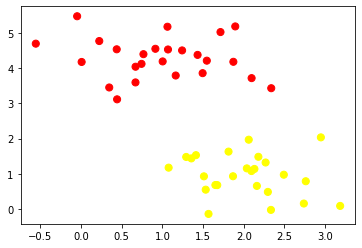

In [15]:
import numpy as np
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

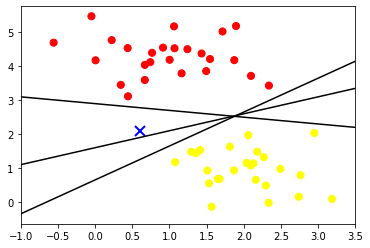

In [16]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='blue', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

All three of the above lines perfectly separate the training data. A new data point, denoted in blue above, would result in very different classification results. So how do we choose the separating line?

### Maximizing the margin: Hinge loss
An intuitive way to identify the "best" separating line is to draw a margin around the line. This margin begins at the line and extends in either direction until it touches a data point of that category.

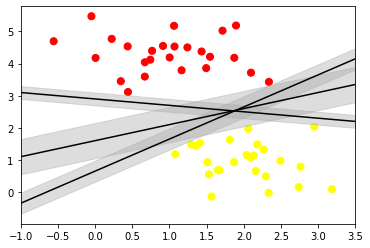

In [17]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);


For the sake of simplicity, we'll only consider separating lines that lie in the middle of any given margin.

So which margin is optimal? If our goal is to separate the two classes as well as possible, then the optimal margin will be the one with the largest width. This minimizes the probability of misclassification of a new data point.

Next, let's try fitting the SVM model from scikit-learn and then plot the decision boundary:

In [18]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear')
model.fit(X, y)

SVC(kernel='linear')

In [19]:
#handy function for plotting
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

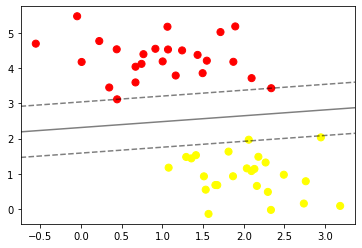

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);


The highlighted circles are the **support vectors**. These are the core points that the model uses to determine the separating boundary. It's important to note that *only* these support vectors are important. All other data points are effectively disregarded during training.
You can specifically extract the support vectors from the trained model as follows:

In [21]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

For further understanding, try the following:

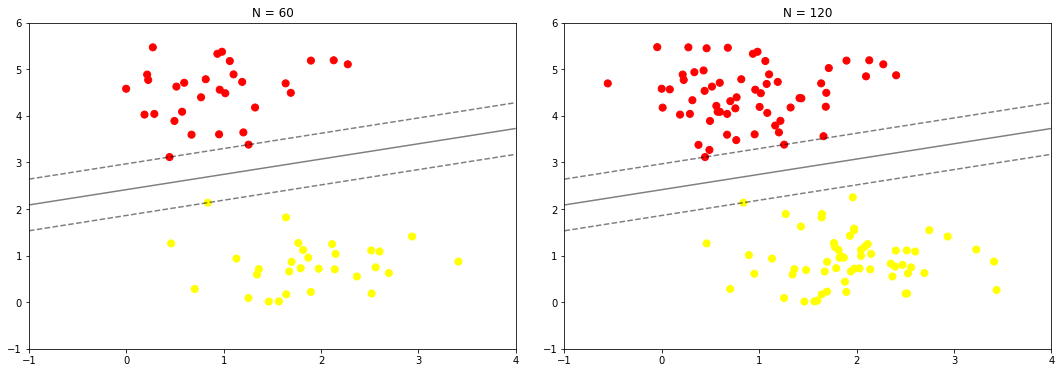

In [22]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points. In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

We can confirm, visually and via the support vectors, that the two models are identical.

**SVMs effectively ignore all data points that aren't support vectors during training**

### Kernel SVM

Where SVM becomes extremely powerful is when it is combined with kernels.
Let's look at some data that is not linearly separable. It is clear that no linear discrimination will ever be able to separate this data.

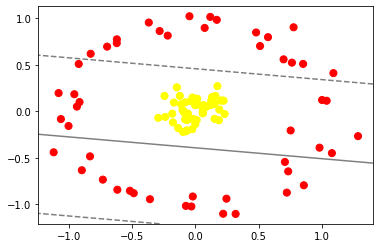

In [23]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

In [24]:
clf = SVC(kernel='rbf', gamma = 'auto', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, gamma='auto')

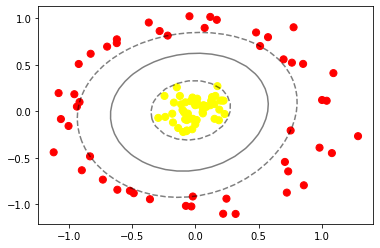

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary. This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

In some cases, the data points may "overlap" and not clearly separable like this:

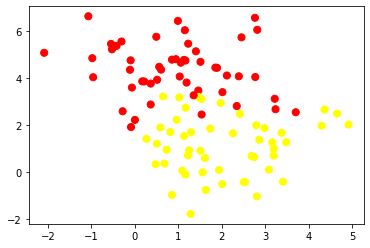

In [26]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as $C$. For very large $C$, the margin is hard, and points cannot lie in it. For smaller $C$, the margin is softer, and can grow to encompass some points.
The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

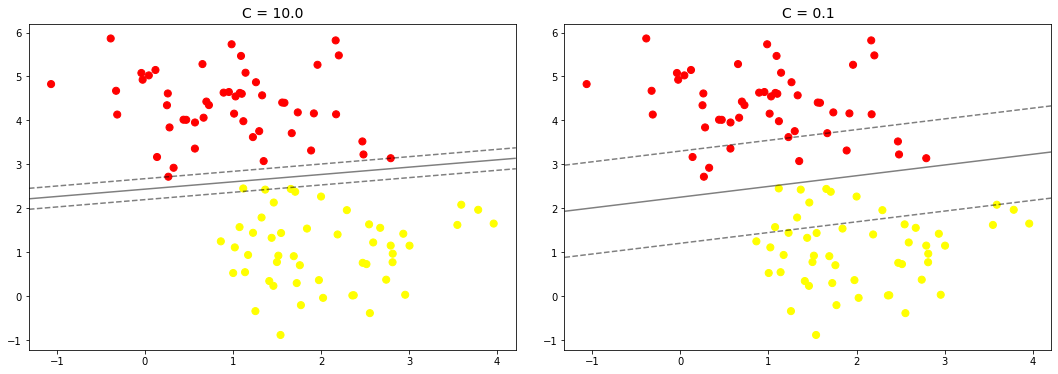

In [27]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

### Understanding Parameters

Now that we have some understanding of the SVM using a toy dataset, let's try it out with an actual (small) dataset, and play around with the different parameters

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm,datasets
%matplotlib inline

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2] # we only take the first two features. We could
 # avoid this ugly slicing by using a two-dim dataset
y = iris.target


In [29]:
#helper function to visualize the hyperplanes of SVM
def plotSVC(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max / x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
 np.arange(y_min, y_max, h))

    plt.subplot(1, 1, 1)
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()



#### Kernel
The kernel parameters selects the type of hyperplane used to separate the data and is one of the most "important" settings for the model. Using `linear` will use a linear hyperplane (a line in the case of 2D data). `rbf` and `poly` are non linear hyper-planes.



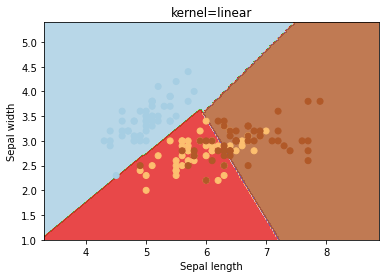

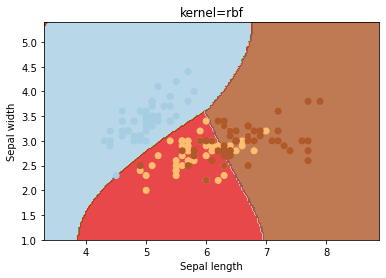

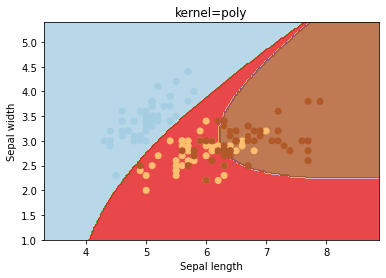

In [30]:
kernels = ['linear', 'rbf', 'poly']
for kernel in kernels:
    svc = svm.SVC(kernel=kernel, gamma='auto').fit(X, y)
    plotSVC('kernel=' + str(kernel))

#### Gamma
Next, we have the gamma parameter for non linear hyperplanes. The higher the gamma value, the more it tries to exactly fit the training data set. Try the following code and observe the changes of the hypreplane with different gammas.

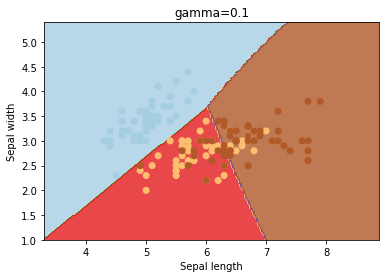

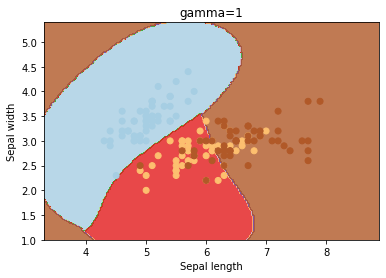

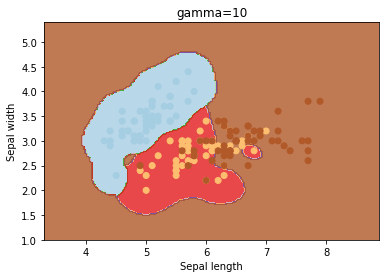

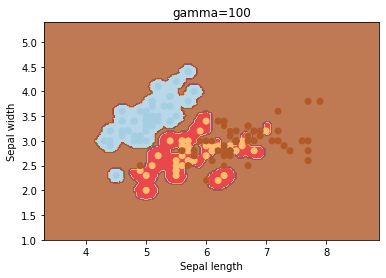

In [31]:
gammas = [0.1, 1, 10, 100]

for gamma in gammas:
    svc = svm.SVC(kernel='rbf', gamma=gamma).fit(X, y)
    plotSVC('gamma=' + str(gamma))


This is the example of overfitting. When the model is too fit with the dataset, new incoming data will be classified wrongly.

#### Penalty Parameter C
C is the penalty parameter of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly.

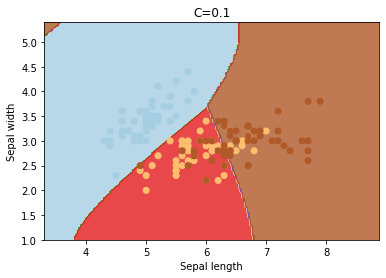

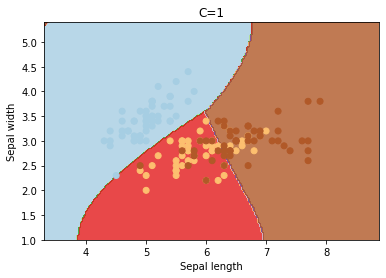

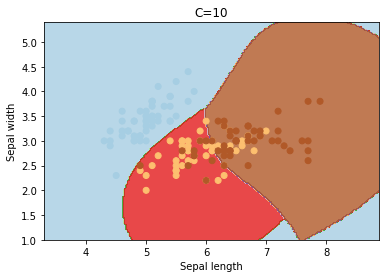

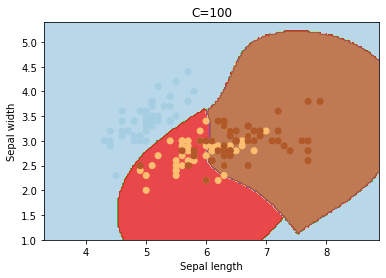

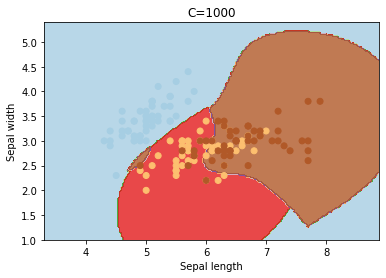

In [32]:
cs = [0.1, 1, 10, 100, 1000]

for c in cs:
    svc = svm.SVC(kernel='rbf', C=c, gamma ='auto').fit(X, y)
    plotSVC('C=' + str(c))

# Degree

Last is the degree parameter used when kernel is set to `poly`. It's basically the degree of the polynomial used to find the hyperplane to split the data.<br>
Using degree=1 is the same as using a `linear` kernel.<br>
Note: Increasing this parameters leads to higher training times, so run the following with caution

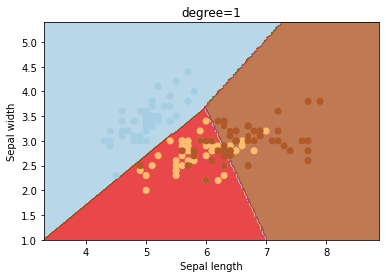

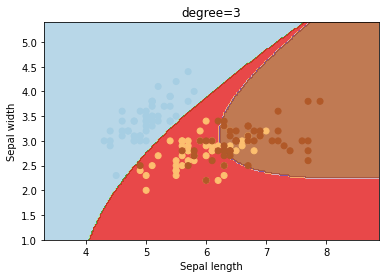

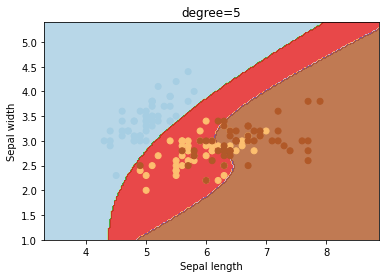

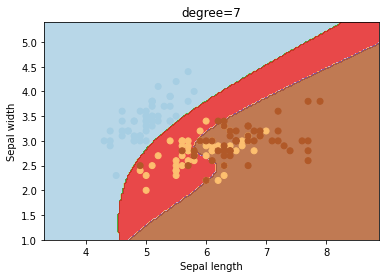

time spent = 52.152371900039725


In [33]:
from timeit import default_timer as timer
start = timer()

degrees = [1,3,5,7]

for degree in degrees:
    svc = svm.SVC(kernel='poly', degree=degree, gamma='auto').fit(X, y)
    plotSVC('degree=' + str(degree))

end = timer()

print('time spent =', end-start)

### Exercise

Perform classification task using the `diabetes.csv` dataset using SVM and then compare and find the best model.<br>
Steps for doing this would include (but not limited to):
1. Training, Validation, Testing set split
2. Data normalization
3. SVM training
4. Parameter tuning and comparison

Common practise for SVM:

- 60% training, 10% validation, 30% test.
- Mini testing to adjust/tune parameter.



---



### For Google Colab Use Only
Skip this section if you are using Jupyter Notebook etc.

1. Read dataset
2. Split training and testing set - train_test_split
3. Split training set to train and validation - train_test_split
4. minmaxscaler & fit transform on train set
5. train svm - fit
6. evaluate result with val - score
7. train svm with diff. parameter
8. evaluation on val also - score

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm,datasets
%matplotlib inline

# import some data to play with
df = pd.read_csv('diabetes.csv')
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [47]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [48]:
from sklearn.preprocessing import StandardScaler  # z-score / standardization
from sklearn.preprocessing import MinMaxScaler # min max

In [49]:
#helper function to visualize the hyperplanes of SVM
def plotSVC(title):
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = (x_max / x_min)/100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
 np.arange(y_min, y_max, h))

    plt.subplot(1, 1, 1)
    Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.title(title)
    plt.show()